<a href="https://colab.research.google.com/github/kaitlynrv/sbux_repo/blob/main/SBUX_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SBUX Data Prep

In [103]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
import yfinance as yf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import detrend

In [104]:
# Load Data, CSV file obtained from Yahoo Finance SBUX page

data_path = '/content/SBUX.csv'
sbux = pd.read_csv(data_path)
sbux

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-01,88.059998,88.879997,86.580002,87.099998,85.288750,6219600
1,2022-11-02,87.269997,88.580002,84.529999,84.580002,82.821159,7653200
2,2022-11-03,84.070000,85.470001,82.970001,84.680000,82.919075,8855100
3,2022-11-04,91.980003,93.599998,90.519997,91.860001,89.949768,20194300
4,2022-11-07,91.669998,92.360001,89.279999,90.449997,88.569092,10190200
...,...,...,...,...,...,...,...
247,2023-10-26,93.809998,94.480003,92.599998,92.669998,92.669998,6201700
248,2023-10-27,92.639999,93.730003,91.769997,92.019997,92.019997,8291900
249,2023-10-30,93.120003,93.709999,92.720001,93.150002,93.150002,7852700
250,2023-10-31,93.169998,93.320000,92.000000,92.239998,92.239998,9308300


In [105]:
sbux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [106]:
#check for any null values
sbux.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [107]:
#convert to date time
sbux['Date'] = pd.to_datetime(sbux['Date'], format="%Y-%m-%d")

# Check the data information
sbux.info()
print(sbux)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       252 non-null    float64       
 2   High       252 non-null    float64       
 3   Low        252 non-null    float64       
 4   Close      252 non-null    float64       
 5   Adj Close  252 non-null    float64       
 6   Volume     252 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.9 KB
          Date       Open       High        Low      Close  Adj Close  \
0   2022-11-01  88.059998  88.879997  86.580002  87.099998  85.288750   
1   2022-11-02  87.269997  88.580002  84.529999  84.580002  82.821159   
2   2022-11-03  84.070000  85.470001  82.970001  84.680000  82.919075   
3   2022-11-04  91.980003  93.599998  90.519997  91.860001  89.949768   
4   2022-11-07  91.669998  92.360001  

#Time Series

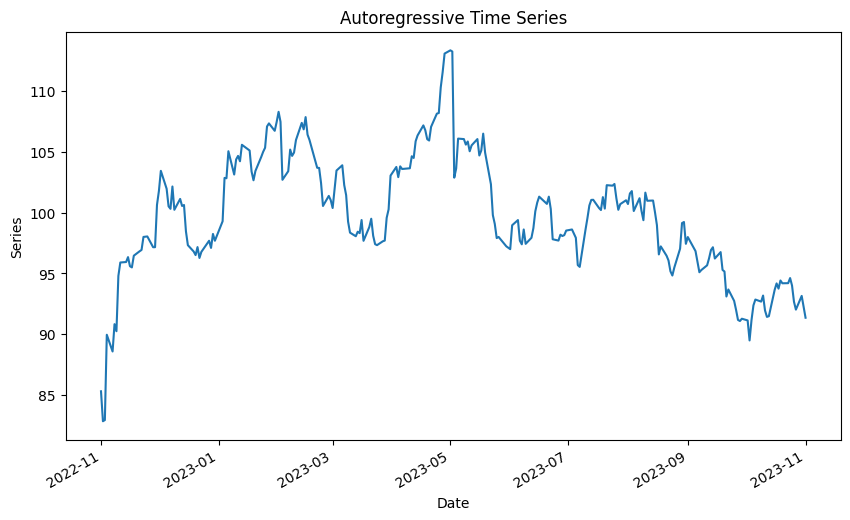

In [108]:
# Create indexed series using adjusted closing prices
sbux_ts = pd.Series(sbux['Adj Close'].values, index=sbux['Date'])

#Plot the series
plt.figure(figsize=(10, 6))
sbux_ts.plot()
plt.title("Autoregressive Time Series")
plt.xlabel("Date")
plt.ylabel("Series")
plt.show()

# Plot ACF and PACF

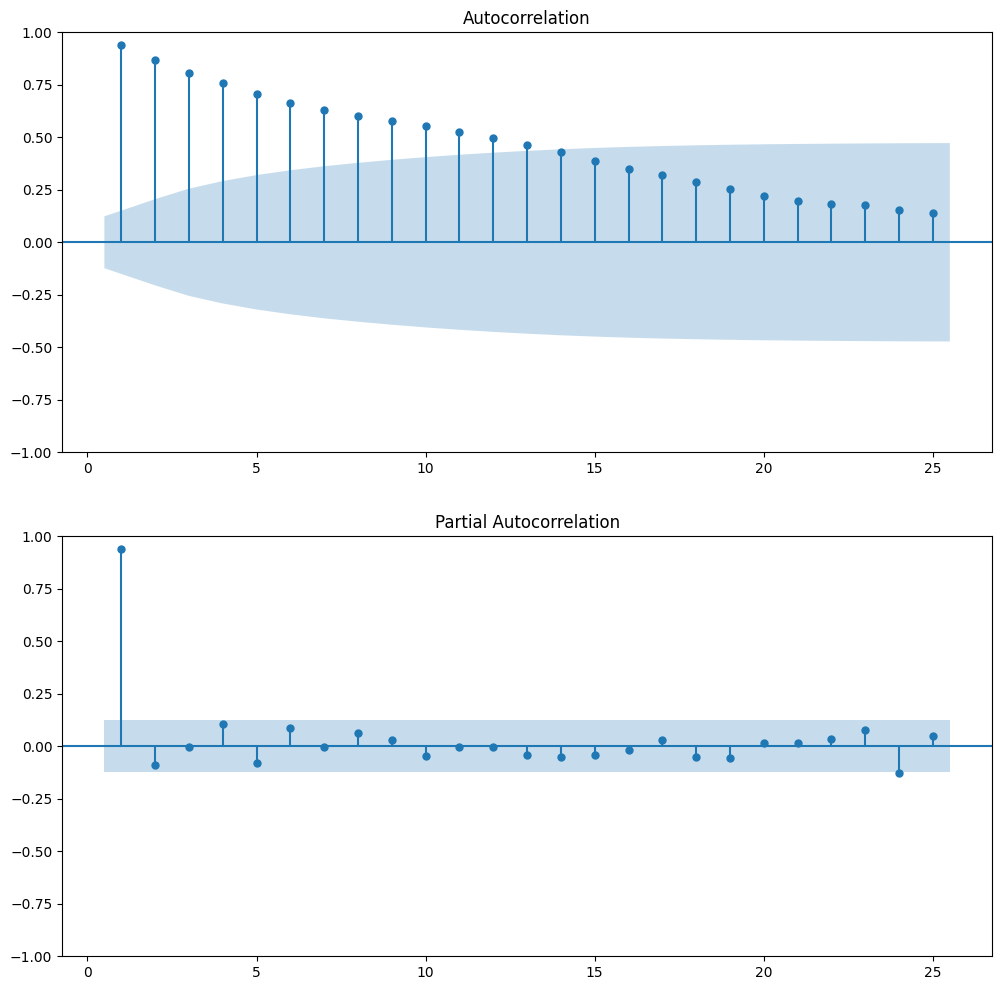

In [109]:
#plotting ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(sbux_ts, ax=ax1, zero=False)
plot_pacf(sbux_ts, ax=ax2, zero=False)
plt.show()

In [110]:
#Dickey Fuller (single mean version) test for stationarity
adfuller(sbux_ts, regression='c')

(-2.889193805521261,
 0.04661911877440679,
 0,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 809.1949318586408)

While the p-value above is below .05 and suggests this data set is stationary with a 95% confidence level, we will still conduct an ARIMA model fitting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -448.861
Date:                Wed, 01 Nov 2023   AIC                            903.722
Time:                        23:01:15   BIC                            914.310
Sample:                             0   HQIC                           907.983
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         97.0895      2.520     38.530      0.000      92.151     102.028
ar.L1          0.9735      0.013     74.596      0.000       0.948       0.999
sigma2         2.0397      0.115     17.735      0.0

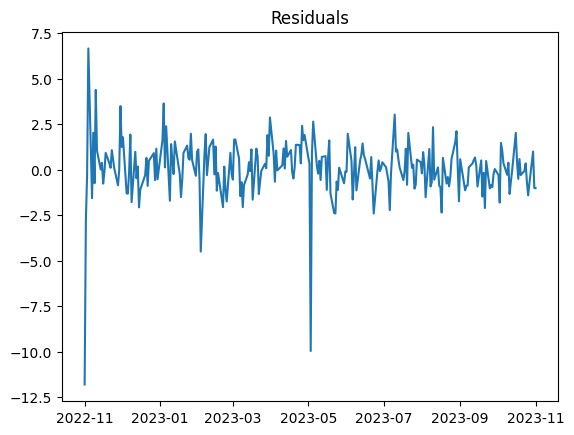

In [111]:
#fit AR(1) model to data and check residuals
fit_AR1 = ARIMA(sbux_ts, order=(1,0,0)).fit()

# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.show()

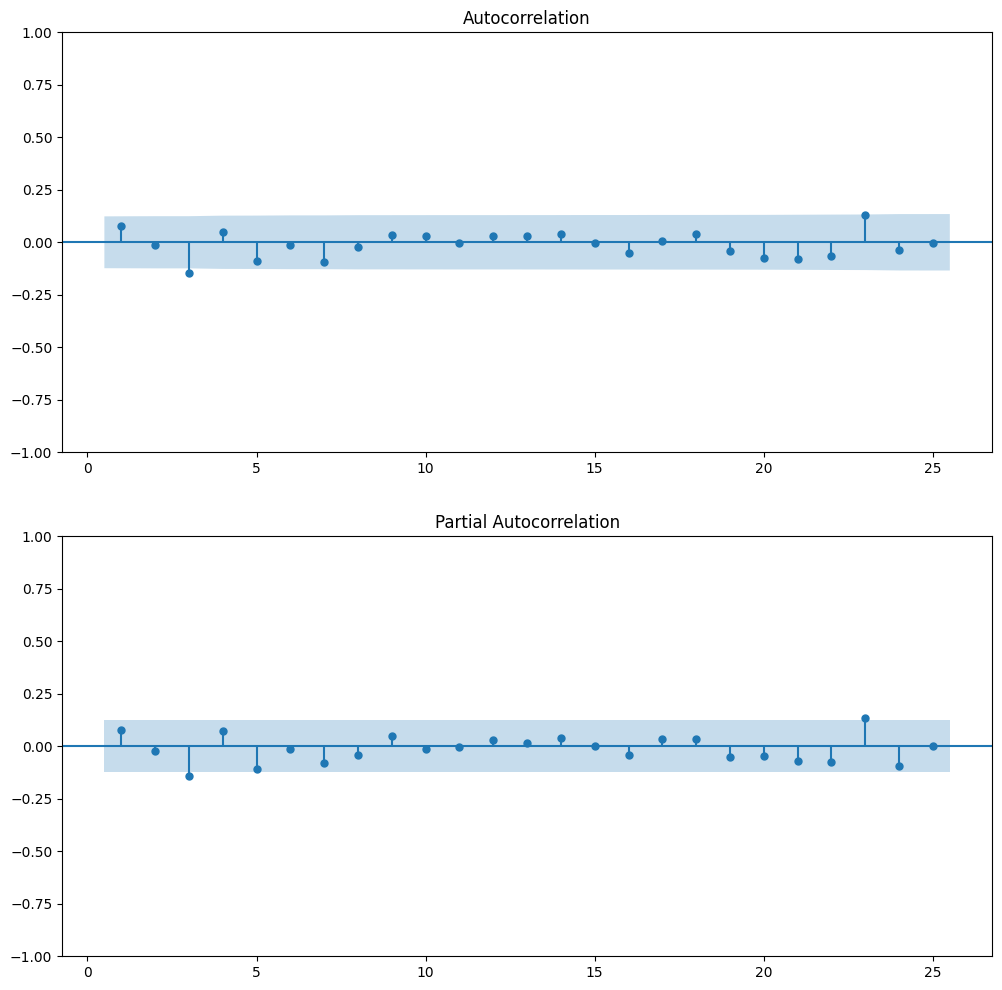

In [112]:
#Check residuals for ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False)
plt.show()


In [113]:
#test residuals for white noise
#execute the Ljung Box test on the kW_Gen series using 10 lags

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.772735,0.236657


The p-value is approximately 0.2367, which is greater than 0.05. Therefore, conclude that there is no strong evidence of serial correlation in the residuals at the 10 lags tested, and the residuals are consistent with white noise

In [120]:
# Define the forecast period (6 months)
forecast_start = '2023-11-02'
forecast_end = '2024-04-02'

# Get the forecast with a daily frequency
forecast = fit_AR1.get_forecast(steps=len(pd.date_range(start=forecast_start, end=forecast_end, freq='D')))

# Extract the predicted mean and confidence intervals
forecasted_mean = forecast.predicted_mean
forecasted_conf_int = forecast.conf_int()

# Create a DataFrame for the forecasted values with a proper date index
forecast_df = pd.DataFrame({'Forecasted Close': forecasted_mean})
forecast_df.index = pd.date_range(start=forecast_start, end=forecast_end, freq='D')

# Display the forecast DataFrame
forecast_df


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecasted Close
2023-11-02,91.502321
2023-11-03,91.650601
2023-11-04,91.794946
2023-11-05,91.935460
2023-11-06,92.072245
...,...
2024-03-29,96.985208
2024-03-30,96.987976
2024-03-31,96.990671
2024-04-01,96.993294


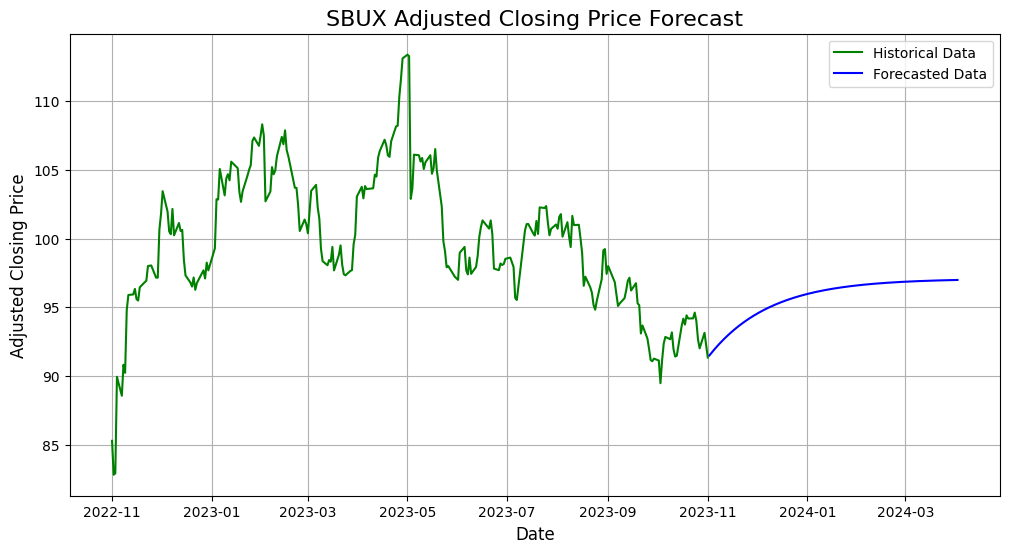

In [121]:
# Plot historical data in green
plt.figure(figsize=(12, 6))
plt.plot(sbux_ts, color='green', label='Historical Data')

# Plot forecasted data in blue
plt.plot(forecast_df['Forecasted Close'], color='blue', label='Forecasted Data')

# Customize the plot
plt.title("SBUX Adjusted Closing Price Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Adjusted Closing Price", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Forecast suggests price will increase in a logistic fashion